<a href="https://colab.research.google.com/github/MariiaKalinina/Kaggle/blob/main/Tver_elastisity_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [17]:
path_to_ser = Path('/content/Tver.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

,#,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water
30,129897,129897,b,"выбоины, трещины",23.648542,1426.840000,2.075533,2.078293,2.212333,1.503667,3.167705,1.861495,3.2595,1.7465
31,129913,129913,b,"пористо-кавернозный, большие каверны",10.171065,119.017000,2.433178,2.425019,4.072333,2.521333,5.099085,2.699025,4.9965,2.5820
32,129914,129914,b,"пористо-кавернозный, на торцах присутствуют бо...",5.877850,0.491424,2.498266,2.536095,5.013000,2.883000,5.491510,2.945640,5.4025,2.9025
33,129937,129937,b,пористо-кавернозный,12.718631,64.508600,2.374723,2.364644,3.926333,2.342333,4.469470,2.513400,4.5515,2.3585


In [36]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [20]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [37]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Vp/Vs air
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN


In [23]:
data[['Vp air', 'Vs air', 'Vp water', 'Vs water', 'Vp oil', 'Vs oil']].describe()

,Vp air,Vs air,Vp water,Vs water,Vp oil,Vs oil
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,4.049354,2.347747,4.734121,2.500788,4.801224,2.647978
std,0.785375,0.394807,0.634691,0.349465,0.684056,0.374006
min,2.212333,1.323000,3.259500,1.718500,3.167705,1.825235
25%,3.514333,2.076667,4.405000,2.233000,4.224880,2.373170
50%,4.042333,2.360000,4.900000,2.582000,4.972040,2.704390
75%,4.839333,2.675000,5.211500,2.723500,5.190400,2.876360
max,5.199333,2.883000,5.674000,2.991500,5.958540,3.269995


In [63]:
data['Vp/Vs air'] = data[['Vp air', 'Vs air']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs water'] = data[['Vp water', 'Vs water']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs oil'] = data[['Vp oil', 'Vs oil']].apply(lambda x: x[0]/x[1], axis=1)

data['Vp Water/Oil Diff'] = data[['Vp water', 'Vp oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)
data['Vs Water/Oil Diff'] = data[['Vs water', 'Vs oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)

In [ ]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [108]:
    ### Moduli Air
data['K air'] = data[['Vp air', 'Vs air', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu air'] = data[['Vs air', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Water
data['K water'] = data[['Vp water', 'Vs water', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu water'] = data[['Vs water', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Oil
data['K oil'] = data[['Vp oil', 'Vs oil', 'Density (oil)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu oil'] = data[['Vs oil', 'Density (oil)']].apply(lambda x: x[1] * x[0]**2, axis=1)

In [109]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Vp/Vs air,Vp/Vs water,Vp/Vs oil,Vp Water/Oil Diff,Vs Water/Oil Diff,K air,Mu air,K water,Mu water,K oil,Mu oil
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,2.134322,1.998302,1.842867,-4.85,-12.25,46.159570,14.326384,48.028807,18.056785,48.450587,23.487506
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,1.665111,1.896623,1.815870,-2.30,-6.46,21.521152,14.952932,40.793349,18.019497,40.324913,20.531503
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,1.759806,1.804075,1.818652,-1.82,-1.03,16.072570,9.113578,21.893623,11.394892,23.087306,11.694747
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,1.763650,1.880947,1.834958,-3.92,-6.27,13.959632,7.855171,21.101203,9.571328,22.092591,10.863045
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,1.625910,1.928486,1.855972,1.41,-2.40,17.592209,13.426620,36.765377,15.410573,33.965842,16.087646


In [65]:
data[['Vp Water/Oil Diff', 'Vs Water/Oil Diff']].describe()

,Vp Water/Oil Diff,Vs Water/Oil Diff
count,33.000000,33.000000
mean,-1.018788,-5.234242
std,7.620490,8.221110
min,-21.120000,-24.470000
25%,-4.850000,-10.100000
50%,-1.770000,-6.180000
75%,1.840000,-2.400000
max,31.430000,25.300000


Text(0, 0.5, 'Absolute Percentage Error, %')

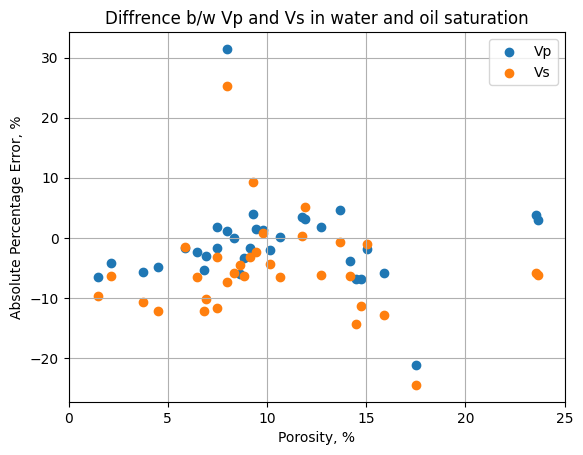

In [71]:
plt.scatter(data['Porosity,%'], data['Vp Water/Oil Diff'], label='Vp')
plt.scatter(data['Porosity,%'], data['Vs Water/Oil Diff'], label='Vs')
plt.title('Diffrence b/w Vp and Vs in water and oil saturation')
plt.legend()
plt.grid()
plt.xlim(0, 25)
plt.xlabel('Porosity, %')
plt.ylabel('Absolute Percentage Error, %')

$Susan, 1992$
https://www.crewes.org/Documents/ResearchReports/1992/1992-12.pdf

https://www.researchgate.net/publication/249866305_Changes_in_dynamic_shear_moduli_of_carbonate_rocks_with_fluid_substitution

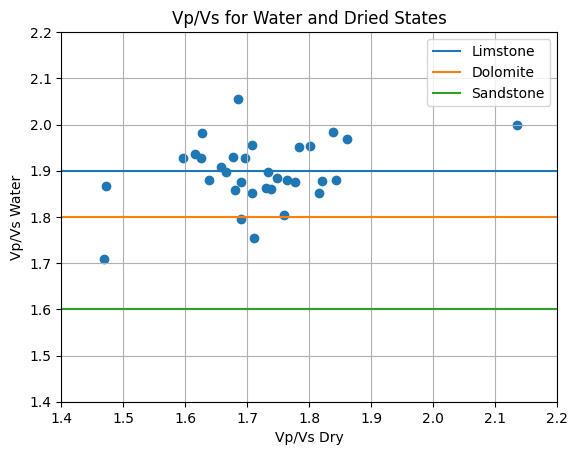

In [79]:
plt.scatter(data['Vp/Vs air'], data['Vp/Vs water'])
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
plt.xlim(1.4, 2.2)
plt.ylim(1.4, 2.2)
plt.title('Vp/Vs for Water and Dried States')
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

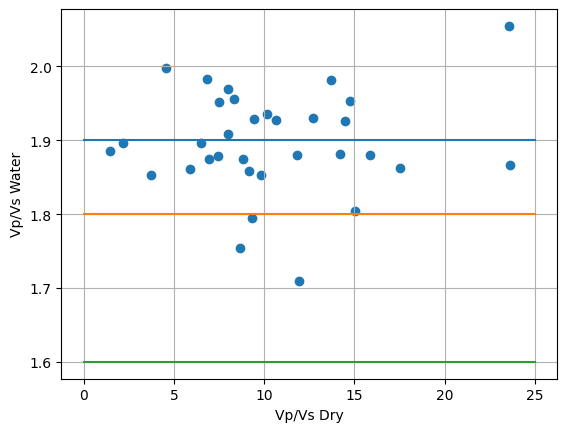

In [77]:
# plt.scatter(data['Porosity,%'], data['Vp/Vs air'], label='air')
plt.scatter(data['Porosity,%'], data['Vp/Vs water'], label='air')
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.grid()

### Vp, Vs, density of minerals
- Calcite Peselnick and Robie (1963) Vp=6.54 Vs=3.35, p=2.71
- Dolomite Ahrens (1995) Vp=6.40; Vs=3.46 p=2.86

In [87]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [88]:
### Calcite
K_calcite, mu_calcite = bulk_mdl([2.71], [6.54], [3.35])

### Dolomite
K_dolomite, mu_dolomite = bulk_mdl([2.86], [6.40], [3.46])

In [89]:
K_calcite, mu_calcite

(75.36040266666667, 30.412975)

In [90]:
K_dolomite, mu_dolomite

(71.49389866666668, 34.238776)

In [125]:
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

In [126]:
def HS_borders(K, μ, f):

  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 + f[0]*(K[0]+4/3*μ[0])**-1))
  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 + f[1]*(K[1]+4/3*μ[1])**-1))
  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 + 2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))
  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 + 2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [92]:
K_matrix, Mu_matrix = K_calcite, mu_calcite

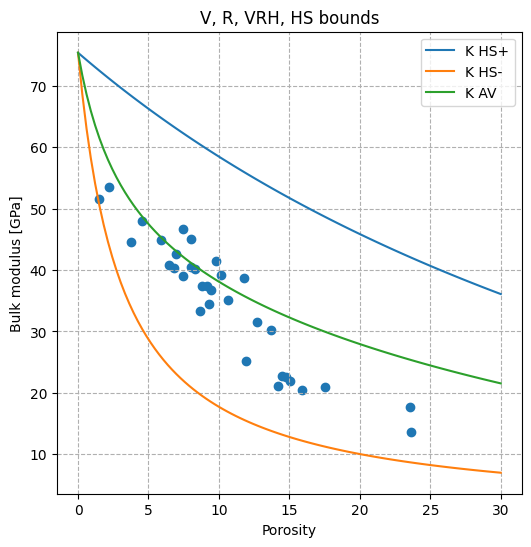

In [110]:
porosity = np.linspace(0, 0.3, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)



plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('HS bounds - Water')

plt.plot(porosity*100, K_up_value,label='K HS+')
plt.plot(porosity*100, K_lo_value,label='K HS-')
plt.plot(porosity*100, K_av_value,label='K AV')

plt.scatter(data['Porosity,%'], data['K water'])

plt.legend(loc='best')
plt.grid(ls='--')

HS bourders for K and Mu moduli in diffrent saturation states.
--> All samples are inside bourdes for which Calcite moduli K and mu were used.

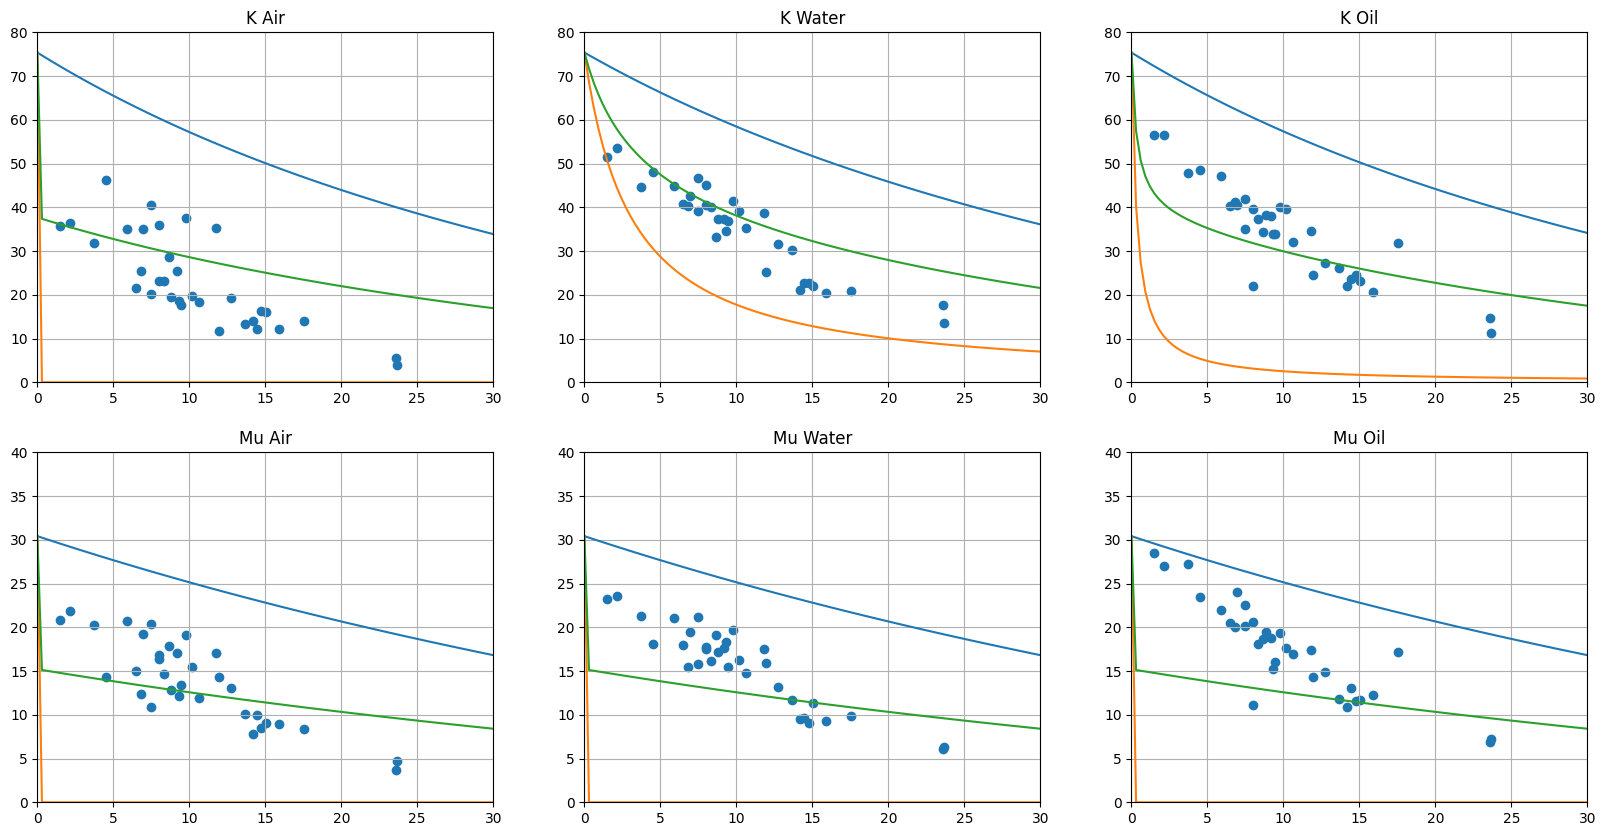

In [136]:
fig = plt.figure(figsize=(20, 10))

porosity = np.linspace(0, 0.3, 100, endpoint=True)

K_matrix, Mu_matrix = K_calcite, mu_calcite

MODULI = {
    "K Air": [data['K air'], K_matrix, K_air, Mu_matrix, Mu_air],
    "K Water":[data['K water'], K_matrix, K_water, Mu_matrix, Mu_water],
    "K Oil" : [data['K oil'],K_matrix, K_oil, Mu_matrix, Mu_oil],
    "Mu Air" : [data['Mu air'], K_matrix, K_air, Mu_matrix, Mu_air],
     "Mu Water" : [data['Mu water'], K_matrix, K_water, Mu_matrix, Mu_water],
     "Mu Oil" : [data['Mu oil'], K_matrix, K_oil, Mu_matrix, Mu_oil]
}

for index, (name, moduli) in enumerate(MODULI.items()):

  K_matrix, K_fluid, Mu_matrix, Mu_fluid = moduli[1], moduli[2], moduli[3], moduli[4]

  K_up_value, K_lo_value, K_av_value = [], [], []
  Mu_up_value, Mu_lo_value, Mu_av_value = [], [], []

  for phi in porosity:
    K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
    K_up, K_lo, K_av, Mu_up, Mu_lo, Mu_av  = HS_borders(K, μ, f)

    K_up_value.append(K_up)
    K_lo_value.append(K_lo)
    K_av_value.append(K_av)

    Mu_up_value.append(Mu_up)
    Mu_lo_value.append(Mu_lo)
    Mu_av_value.append(Mu_av)


  ax = plt.subplot(2, 3, index + 1)
  plt.scatter(data['Porosity,%'], moduli[0])

  if index < 3: ### K moduli (upper plots)
    plt.plot(porosity*100, K_up_value,label='K HS+')
    plt.plot(porosity*100, K_lo_value,label='K HS-')
    plt.plot(porosity*100, K_av_value,label='K AV')
    plt.ylim(0, 80)

  else: ### Mu moduli (bottom plots)
    plt.plot(porosity*100, Mu_up_value,label='K HS+')
    plt.plot(porosity*100, Mu_lo_value,label='K HS-')
    plt.plot(porosity*100, Mu_av_value,label='K AV')
    plt.ylim(0, 40)

  plt.grid()
  plt.xlim(0, 30)
  plt.title(f'{name}')

### GSA isotropic

In [137]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

In [138]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.zeros((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

In [139]:
M_C11 = K_matrix + 4/3*Mu_matrix
M_C44 = Mu_matrix
M_C12 = M_C11 - 2*M_C44

C_mtrx = np.zeros((6,6))
C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

C_mtrx = mat2tens(C_mtrx, compl=False)
C_c = C_mtrx


k, mu = K_air, Mu_air
lambda_ = k - 2 * mu / 3
c11 = lambda_ + 2 * mu
c12 = lambda_
c44 = mu

Fl_C11 = c11
Fl_C12 = c12
Fl_C44 = (Fl_C11 - Fl_C12)*0.5

C_fl = np.zeros((6, 6))
C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

C_fl = mat2tens(C_fl, compl=False)

In [142]:
import numpy as np
import scipy.integrate as integrate

pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }


    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):


                  integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + \
                                 func(θ, φ, (j, k, l, i))* np.sin(θ) +\
                                 func(θ, φ, (i, l, k, j))* np.sin(θ) +\
                                 func(θ, φ, (j, l, k, i))* np.sin(θ))

                  integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                  integrals[i, j, k, l] = integral / (-16 * pi)

    A_klnm = integrals
    return A_klnm

In [144]:
def result_rotation_sh(theta, phi, psi, Cij, position):

  c11, c12, c44 = Cij[0], Cij[1], Cij[2]
  i,j,k,l = int(position[0]), int(position[1]), int(position[2]), int(position[3])
  # i,j = int(position[0]), int(position[1])

  c1, c2, c3 = np.cos(theta), np.cos(psi), np.cos(phi)
  s1, s2, s3 = np.sin(theta), np.sin(psi), np.sin(phi)

  l1 = c2*c3 - c1*s2*s3
  l2 = -c2*s3 - c1*s2*c3
  l3 = s1*s2

  m1 = s2*c3 + c1*c2*s3
  m2 = -s2*s3 + c1*c2*c3
  m3 = -s1*c2

  n1 = s1*s3
  n2 = s1*c3
  n3 = c1

  c = c11 - c12 - 2*c44

  c11_new = c11 - 2*c*(l1**2*m1**2 + m1**2*n1**2 + n1**2*l1**2)
  c12_new = c12 + c* (l1**2*l2**2 + m1**2*m2**2 + n1**2*n2**2)
  c44_new = c44 + c* (l2**2*l3**2 + m2**2*m3**2 + n2**2*n3**2)

  C_new = np.zeros((6, 6))
  C_new[0,0] = C_new[1, 1] = C_new[2,2] = c11_new
  C_new[0,1] = C_new[0,2] = C_new[1,0] = C_new[1,2] = C_new[2,0] = C_new[2,1] = c12_new
  C_new[3,3] = C_new[4,4] = C_new[5,5] = c44_new

  A_new = mat2tens(C_new, compl=False)

  return A_new[i,j,k,l]
  # return C_new[i,j]

In [140]:
def effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

                  ### Числитель

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))

  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid

  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)

  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)

  ### sum
  rslt_num = ((1-porosity)*num_mtrx + porosity*num_fl)
  #       ### -----------


   ### Знаменатель

  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity)
  result_fl = (x_fl1 @ g_inv_fl1) * porosity
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl)


        ### Effective Cij
  # eff = rslt_num_A @ rslt_dnmntr_B
  eff = rslt_num @ rslt_dnmntr
  # print(eff)

  new_eff = np.zeros((3,3,3,3))

  for i in range(3):
    for j in range(3):
      for k in range(3):
        for l in range(3):

          A = eff

          # integrand = (lambda psi, phi, theta, i=i, j=j, k=k, l=l: rotation(psi, phi, theta, A, (i, k, l, j))* np.sin(theta))
          # integral, _ = integrate.tplquad(integrand, (0, 2*np.pi), (0, 2*np.pi), (0, np.pi))

          Cij = [A[0,0], A[0,1], A[3,3]]


          integrand = (lambda theta, phi, psi, i=i, j=j, k=k, l=l: result_rotation_sh(theta, phi, psi, Cij,(i,j,k,l))* np.sin(theta))
          integral,_ = integrate.nquad(integrand, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
          new_eff[i, j, k, l] =  integral
          # print(i,j,k,l, new_eff[i, j, k,l])

  Q = (lambda theta, phi, psi: np.sin(theta))
  integral_Q,_ = integrate.nquad(Q, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
  new_eff *= integral_Q**-1

  result = tens2mat(new_eff, compl=False)
  print(np.round(result, 5))

  return result[0,0], result[0,2], result[3,3]

In [ ]:
c11, c12, c44 = [], [], []
# porosity = np.arange(0.0, 1.1, 0.1)
porosity = 4.52/100

AR = np.linspace(1, 1000, 20)

g_m = tensor_g(C_c, [1, 1, 1])

for i in AR:

  g_fl = tensor_g(C_c, [i, i, 1])

  a, b, c =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity)

  print(a, b, c)

  c11.append(a)
  c12.append(b)
  c44.append(c)

[[103.60409  47.76537  47.76537   0.        0.        0.     ]
 [ 47.76537 103.60409  47.76537   0.        0.        0.     ]
 [ 47.76537  47.76537 103.60409   0.        0.        0.     ]
 [  0.        0.        0.       27.91936   0.        0.     ]
 [  0.        0.        0.        0.       27.91936   0.     ]
 [  0.        0.        0.        0.        0.       27.91936]]
103.60408742366062 47.76537174913471 27.91935783726294
[[78.04628 39.34071 39.34071  0.       0.       0.     ]
 [39.34071 78.04628 39.34071  0.       0.       0.     ]
 [39.34071 39.34071 78.04628  0.       0.       0.     ]
 [ 0.       0.       0.      19.35279  0.       0.     ]
 [ 0.       0.       0.       0.      19.35279  0.     ]
 [ 0.       0.       0.       0.       0.      19.35279]]
78.04627975086696 39.34070590440059 19.352786923233193
[[72.09312 38.83433 38.83433  0.       0.       0.     ]
 [38.83433 72.09312 38.83433  0.       0.       0.     ]
 [38.83433 38.83433 72.09312  0.       0.       0.    

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


[[67.94478 38.82968 38.82968  0.       0.       0.     ]
 [38.82968 67.94478 38.82968  0.       0.       0.     ]
 [38.82968 38.82968 67.94478  0.       0.       0.     ]
 [ 0.       0.       0.      14.55755  0.       0.     ]
 [ 0.       0.       0.       0.      14.55755  0.     ]
 [ 0.       0.       0.       0.       0.      14.55755]]
67.94477926589701 38.82968228026742 14.557548492814792
[[66.97422 38.86675 38.86675  0.       0.       0.     ]
 [38.86675 66.97422 38.86675  0.       0.       0.     ]
 [38.86675 38.86675 66.97422  0.       0.       0.     ]
 [ 0.       0.       0.      14.05373  0.       0.     ]
 [ 0.       0.       0.       0.      14.05373  0.     ]
 [ 0.       0.       0.       0.       0.      14.05373]]
66.97421866730497 38.86675129882022 14.053733684242378
[[66.29533 38.90087 38.90087  0.       0.       0.     ]
 [38.90087 66.29533 38.90087  0.       0.       0.     ]
 [38.90087 38.90087 66.29533  0.       0.       0.     ]
 [ 0.       0.       0.      13.6

In [ ]:
data_gsa = {
    'C11': c11,
    'C12': c12,
    'C44': c44
}

inversion = pd.DataFrame(data_gsa)
inversion['Density (water)'] = data['Density (water)']

inversion['Vp air'] = inversion[['C11', 'Density (water)']].apply(lambda x: np.sqrt(x[0] / x[1]), axis=1)
inversion['Vs air'] = inversion[['C44', 'Density (water)']].apply(lambda x: np.sqrt(x[0] / x[1]), axis=1)